In [16]:
# Import necessary modules
import numpy as np
import pytest
import torch
from quafu.algorithms.ansatz import QuantumNeuralNetwork
from quafu.algorithms.gradients import compute_vjp, jacobian
from quafu.algorithms.interface.torch import ModuleWrapper, TorchTransformer
from quafu.algorithms.templates.angle import AngleEmbedding
from quafu.algorithms.templates.basic_entangle import BasicEntangleLayers
from quafu.circuits.quantum_circuit import QuantumCircuit
from quafu.elements import Parameter
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [17]:
# Create a synthetic dataset
def generate_random_dataset(num_inputs, num_samples):
    """
    Generate random dataset

    Args:
        num_inputs: dimension of input data
        num_samples: number of samples in the dataset
    """
    # Generate random input coordinates using PyTorch's rand function
    x = 2 * torch.rand([num_samples, num_inputs], dtype=torch.double) - 1

    # Calculate labels based on the sum of input coordinates
    y01 = (torch.sum(x, dim=1) >= 0).to(torch.long)

    # Convert to one-hot vector
    y = torch.zeros(num_samples, 2)  # Two classes (0 and 1)
    y[torch.arange(num_samples), y01] = 1

    # Create a PyTorch dataset
    dataset = TensorDataset(x, y)

    return dataset

dataset = generate_random_dataset(2, 100)

x = dataset.tensors[0]

Text(0.5, 1.0, 'Random Dataset')

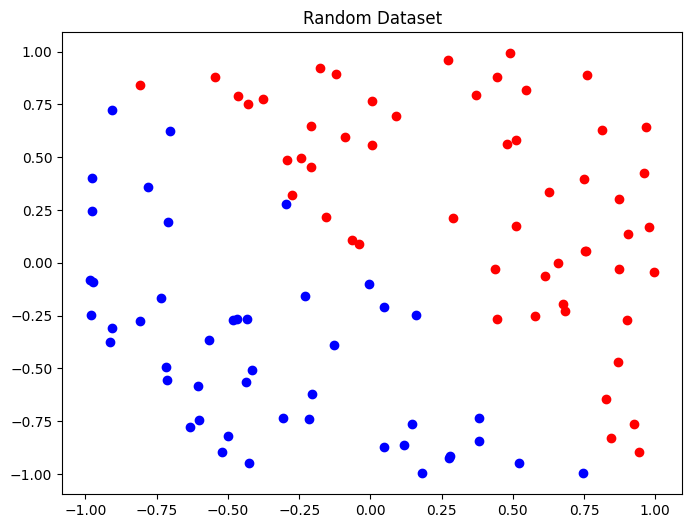

In [18]:
# Virtualize the data
import matplotlib.pyplot as plt

# Extract x and y from dataset
x = dataset.tensors[0]
y = dataset.tensors[1]

# Plotting the data points with different colors based on labels
plt.figure(figsize=(8, 6))

# Extract coordinates for each class
x_class0 = x[y[:, 0] == 1]
x_class1 = x[y[:, 1] == 1]

# Plot points for each class with different colors
plt.scatter(x_class0[:, 0], x_class0[:, 1], color='blue', label='Class 0')
plt.scatter(x_class1[:, 0], x_class1[:, 1], color='red', label='Class 1')

plt.title('Random Dataset')

In [19]:
# Create a quantum classifier using pyquafu
num_qubits = 2
weights = np.random.randn(num_qubits, num_qubits)
encoder_layer = AngleEmbedding(np.random.random((num_qubits,)), num_qubits=2)
entangle_layer = BasicEntangleLayers(weights, num_qubits=num_qubits)
qnn = QuantumNeuralNetwork(num_qubits, encoder_layer + entangle_layer)

# Convert to torch module
model = ModuleWrapper(qnn)

In [12]:
# Virtualize the circuit
qnn.draw_circuit()

q[0]  --RX(0.463)----RX(0.752)-----*----RX(1.666)----*--
                                   |                 |  
q[1]  --RX(0.113)----RX(-0.267)----+----RX(0.915)----+--


In [20]:
learning_rate = 0.1
batch_size = 8
num_epochs = 5

# Train the classifier
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters
        optimizer.step()

        print(f" ----- Loss: {loss.item()}")

    # Print the loss
    print(f"Epoch {epoch + 1}/{num_epochs}: Loss = {loss.item()}")

# Evaluate the model on the dataset
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in data_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

 ----- Loss: 0.47016352457238486
 ----- Loss: 0.5602389247262449
 ----- Loss: 0.5042052124440095
 ----- Loss: 0.44303089908003146
 ----- Loss: 0.485680678548877
 ----- Loss: 0.5203317992118561
 ----- Loss: 0.471911751745741
 ----- Loss: 0.44851506067720437
 ----- Loss: 0.3789606888362804
 ----- Loss: 0.504474843649149
 ----- Loss: 0.561150143374328
 ----- Loss: 0.39283003340155154
 ----- Loss: 0.5613422945489938
Epoch 1/5: Loss = 0.5613422945489938
 ----- Loss: 0.5401680108296921
 ----- Loss: 0.4154153601181712
 ----- Loss: 0.4387543996148419
 ----- Loss: 0.3729660315631854
 ----- Loss: 0.5619182557240855
 ----- Loss: 0.5339458227153231
 ----- Loss: 0.45763721856315454
 ----- Loss: 0.3940893331638052
 ----- Loss: 0.43448165556324003
 ----- Loss: 0.4763397232856658
 ----- Loss: 0.3763355925204098
 ----- Loss: 0.3768708300255989
 ----- Loss: 0.38468797851758657
Epoch 2/5: Loss = 0.38468797851758657
 ----- Loss: 0.4688030109129038
 ----- Loss: 0.40239612992750523
 ----- Loss: 0.4630986822